# Notebook for getting S$_{14}$s of resonators vs 

Loading libraries requred below:

In [13]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [14]:
import time
import pickle
import sys
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
import os

In [15]:
from drivers.Agilent_PNA_L import *
from drivers.znb import *

### Setting the name for the sample

In [16]:
#sample_name = "Xmon_2Q_holes(1808_068-3)" #sample name will be used in the filenames
sample_name = "Xmon-1810-008-2"
s_param = "S14" # specify where the sample is connected

### Getting the general view S$_{21}$ scan of the sample and detect resonator positions

In [17]:
# vna = Agilent_PNA_L("PNA-L2") # loading the vector network analyser object from the driver
vna = Znb("ZNB")

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "C:\Users\lab128\AppData\Local\conda\conda\envs\qubit-measurements\lib\site-packages\pyvisa\resources\resource.py", line 108, in __del__
    self.close()
  File "C:\Users\lab128\AppData\Local\conda\conda\envs\qubit-measurements\lib\site-packages\pyvisa\resources\resource.py", line 244, in close
    self.visalib.close(self.session)
  File "C:\Users\lab128\AppData\Local\conda\conda\envs\qubit-measurements\lib\site-packages\pyvisa\ctwrapper\functions.py", line 394, in close
    return library.viClose(session)
  File "C:\Users\lab128\AppData\Local\conda\conda\envs\qubit-measurements\lib\site-packages\pyvisa\ctwrapper\highlevel.py", line 188, in _return_handler
    raise errors.VisaIOError(ret_value)
pyvisa.errors.VisaIOError: VI_ERROR_CLOSING_FAILED (-1073807338): The VISA driver failed to properly close the session or object reference. This might be due to an error freeing internal or OS resources, a fa

In [18]:
vna.select_S_param(s_param)

In [19]:
vna.sweep_hold()

In [20]:
vna.set_average_mode("REDUCE")

Setting the parameters of the scan:

In [21]:
vna.set_xlim(5e9, 8e9) # setting the scan area
vna.set_bandwidth(1000)
vna.set_nop(10001)
vna.set_averages(1)
vna.set_power(0)

In [22]:
vna.prepare_for_stb()
vna.sweep_single() # triggering the sweep
vna.wait_for_stb()
vna.autoscale_all()

In [11]:
def guess_scan_areas(freqs, sdata, area_size, depth):
    '''
    Function to get the approximate positions of the resonator dips and return small areas around them
    Parameters:
    -----------
        area_size : double
        Sets the diams of the returned scan areas (Hz)
        
        depth : double
        Count everything deeper than median transmission depth near a minimum as a resonator dip. 
        Should be chosen manually each time
    Returns:
        scan_areas : list
        A list of tuples each representing an area in frequency presumably around the resonator dips
    '''
    freqs, amps = vna.get_frequencies(), 20*log10(abs(vna.get_sdata()))
    window = 100
    extrema = argrelextrema(amps, np.less, order=window)[0]
    deep_minima = []
    for extremum in extrema:
        mean_transmission = median(amps[extremum-window//2:extremum+window//2])
        if amps[extremum]<mean_transmission-depth:
            deep_minima.append(freqs[extremum])
    return [(m-area_size/2, m+area_size/2) for m in deep_minima]

In [24]:
scan_areas = guess_scan_areas(1e6, 0, 50e6, 3)[:]
#scan_areas[:10], len(scan_areas)
scan_areas, len(scan_areas)

([(6452800000.0, 6502800000.0),
  (6547900000.0, 6597900000.0),
  (6639700000.0, 6689700000.0),
  (6731800000.0, 6781800000.0),
  (6820000000.0, 6870000000.0),
  (6911800000.0, 6961800000.0),
  (7432000000.0, 7482000000.0),
  (7626400000.0, 7676400000.0)],
 8)

In [15]:
# manual override for the scan areas, don't use if guessing succeeded
# scan_areas = [(8.09e9, 8.096e9),(8357650000.0, 8362650000.0)] 
# scan_areas.append((7.7e9, 7.8e9))
# scan_areas[7] = (7.737e9, 7.741e9)
# scan_areas.insert(-1, (7.48e9, 7.488e9))
# del scan_areas[-2:]
#scan_areas, len(scan_areas)

#([(7502280000.0, 7522280000.0),
#  (7598880000.0, 7618880000.0),
#  (7679520000.0, 7699520000.0),
#  (7783120000.0, 7803120000.0),
#  (7868520000.0, 7888520000.0),
#  (7969880000.0, 7989880000.0),
#  (8468280000.0, 8488280000.0),
#  (8717200000.0, 8737200000.0)],
# 8)

<IPython.core.display.Javascript object>


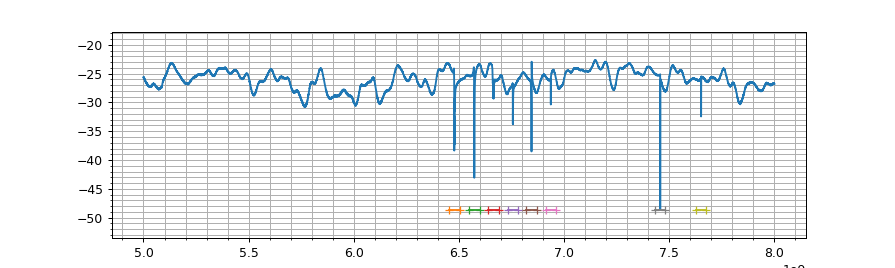

In [25]:
save_graph = True

plt.plot(vna.get_frequencies(), 20*log10(abs(vna.get_sdata())))
# plt.plot(vna.get_frequencies(), unwrap(angle(vna.get_sdata())))

for scan_area in scan_areas:
    plt.plot(scan_area, ones(2)*min(20*log10(abs(vna.get_sdata()))), marker="+")
        
# plt.xlim(scan_areas[1]) # the x-axis limits may are set to a certain scan area to check whether it was guessed correctly
plt.ylim(min(20*log10(abs(vna.get_sdata())))-5,max(20*log10(abs(vna.get_sdata())))+5)
# plt.xlim(5.0e9, 8.0e9)
plt.minorticks_on()
plt.grid(which="both")
plt.gcf().set_size_inches(10, 3)

# Here the first datafile is created. It is placed in a folder with current date which is also created below.

if save_graph:
    try:
        os.mkdir("./data/"+str(datetime.datetime.now().date()))
    except FileExistsError:
        pass
    with open("./data/"+str(datetime.datetime.now().date())+"/"+sample_name+".pkl", "wb") as f:
        pickle.dump((vna.get_frequencies(), vna.get_sdata()), f)
        
    plt.savefig("./data/"+str(datetime.datetime.now().date())+"/"+sample_name+'.pdf')    
    plt.savefig("./data/"+str(datetime.datetime.now().date())+"/"+sample_name+'.png')         

# Recording a zoomed scan inside each scan area at each power

In [61]:
power_scans = {}
vna.set_nop(1001)
vna.set_bandwidth(1000)
powers = linspace(-40, 10, 51) # the powers we are using to scan through

First we make noise calibration to make sure we will not perform redundant averaging:

In [62]:
def theory_noise_amps_pow(power, exponent, max_noise):
    return max_noise*exp(-power*exponent)
# def theory_noise_amps_avg(average, max_noise):
#     return max_noise/sqrt(average)
def calibrate_noise(scan_area, powers):
    noises = []
    powers = powers[::]
    vna.set_center(mean(scan_area)+10e6)
    vna.set_span(1)
    vna.set_averages(1)
    for power in powers:
        vna.set_power(power)
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        noises.append(vna.get_sdata())
        print("\rPower:", power, end="")
    noise_amps = [sqrt(mean((abs(noise) - mean(abs(noise)))**2))/mean(abs(noise)) for noise in noises] 
    opt_params = curve_fit(theory_noise_amps_pow, powers, noise_amps, p0=(0.01,0.1))[0]
    return opt_params, noise_amps

In [63]:
opt_params, noise_amps = calibrate_noise(scan_areas[0], powers[5::5])

Power: 10.00

In [64]:
plot(theory_noise_amps_pow(powers[5::5], *opt_params))
plot(noise_amps, '--o')

In [60]:
vna.sweep_hold() #если лазил руками в VNA

In [65]:
time_start = datetime.datetime.now()
print("Started at:", time_start)

print(powers[:5]) # to check the powers are nice whole numbers

# Beginning the scan here             
for scan_area in scan_areas[:]:
    S21s = []
    
    opt_params, noise_amps = calibrate_noise(scan_area, powers[5::10])
    averages_arr = around(500*theory_noise_amps_pow(powers, *opt_params)**2)
    averages_arr[averages_arr==0]=1
    vna.set_xlim(*scan_area)
    
    for power, averages in zip(powers, averages_arr):
        vna.set_power(power)
        vna.set_averages(averages)
        print("\r"+str(scan_area), "avg: "+str(averages), "power:"+str(power), end=" ", flush=True)
        
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        
        vna.autoscale_all()
        S21s.append((vna.get_frequencies(), vna.get_sdata()))
    power_scans[scan_area] = S21s
    print("Done!")
with open("./data/"
          +str(time_start.date())\
          +"/"+sample_name+"_resonators_on_power.pkl", "wb") as f:
    pickle.dump((scan_areas, powers, power_scans), f)

Started at: 2019-01-16 16:12:58.410409
[-40. -39. -38. -37. -36.]
(2559000000.0, 2609000000.0) avg: 1.0 power:10.0   Done!
(2671000000.0, 2721000000.0) avg: 1.0 power:10.0   Done!
(2926000000.0, 2976000000.0) avg: 1.0 power:10.0  Done!
(3180000000.0, 3230000000.0) avg: 1.0 power:10.0  Done!
(3434000000.0, 3484000000.0) avg: 1.0 power:10.0  Done!
(3687000000.0, 3737000000.0) avg: 1.0 power:10.0  Done!
(3939000000.0, 3989000000.0) avg: 1.0 power:10.0  Done!
(4188000000.0, 4238000000.0) avg: 1.0 power:10.0  Done!
(4436000000.0, 4486000000.0) avg: 1.0 power:10.0  Done!
(4683000000.0, 4733000000.0) avg: 1.0 power:10.0  Done!
(4927000000.0, 4977000000.0) avg: 1.0 power:10.0  Done!
(5171000000.0, 5221000000.0) avg: 1.0 power:10.0  Done!
(5416000000.0, 5466000000.0) avg: 1.0 power:10.0  Done!
(5662000000.0, 5712000000.0) avg: 1.0 power:10.0  Done!
(5908000000.0, 5958000000.0) avg: 1.0 power:10.0  Done!
(6155000000.0, 6205000000.0) avg: 1.0 power:10.0  Done!
(6400000000.0, 6450000000.0) avg: 1.

## Dependence from bandwith

In [66]:
scan_area = scan_areas[-1]
bw_list = [1e4,1e3,1e2,1e1]
powers = linspace(-40,0,11)

In [67]:
time_start = datetime.datetime.now()
print("Started at:", time_start)

print(powers[:5]) # to check the powers are nice whole numbers

# Beginning the scan here             
for bw in bw_list:
    
    S21s = []
    vna.set_bandwidth(bw)
    opt_params, noise_amps = calibrate_noise(scan_area, powers[2::3])
    averages_arr = around(50*theory_noise_amps_pow(powers, *opt_params)**2)
    averages_arr[averages_arr==0]=1
    vna.set_xlim(*scan_area)
    
    for power, averages in zip(powers, averages_arr):
        vna.set_power(power)
        
        vna.set_averages(averages)
        print("\r"+str(scan_area), "avg: "+str(averages), "power:"+str(power), end=" ", flush=True)
        
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        
        vna.autoscale_all()
        S21s.append((vna.get_frequencies(), vna.get_sdata()))
    power_scans[bw] = S21s
    print("Done!")
with open("./data/"
          +str(time_start.date())\
          +"/"+sample_name+"TII_resonator_on_bw.pkl", "wb") as f:
    pickle.dump((scan_areas, powers, bw_list, power_scans), f)

Started at: 2019-01-16 17:23:33.577294
[-40. -36. -32. -28. -24.]
(8424000000.0, 8474000000.0) avg: 1.0 power:0.0    Done!
(8424000000.0, 8474000000.0) avg: 1.0 power:0.0    Done!
(8424000000.0, 8474000000.0) avg: 1.0 power:0.0    Done!
(8424000000.0, 8474000000.0) avg: 1.0 power:0.0   Done!


In [57]:
#with open("./data/"\
#          +str(time_start.date())\
#          +"/"+sample_name+"_resonators_on_power.pkl", "wb") as f:
#    pickle.dump((scan_areas, powers, power_scans), f)

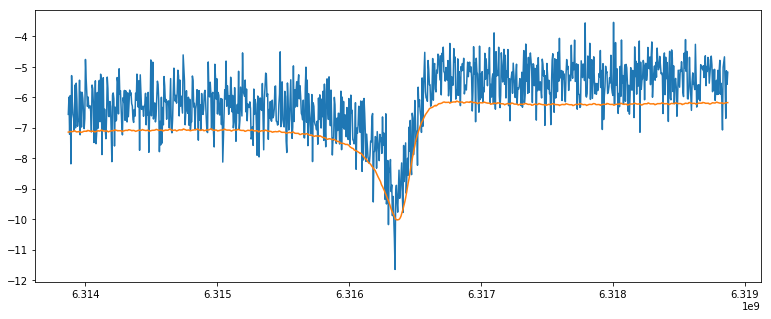

In [26]:
scan_area = scan_areas[7]
plt.plot(power_scans[scan_area][0][0], 20*log10(abs(power_scans[scan_area][0][1])))
plt.plot(power_scans[scan_area][-1][0], 20*log10(abs(power_scans[scan_area][-1][1])))
plt.gcf().set_size_inches(13,5)

До сих пор

In [ ]:
vna.set_xlim(*scan_areas[1])

##  Noise calibration

In [ ]:
peak_vicinity = mean(scan_areas[0])+linspace(-1, 1, 2)

In [ ]:
power_scans = {}
vna.set_nop(1000)
vna.set_bandwidth(500)
vna.set_averages(1)

In [ ]:
powers = linspace(-60, -30, 31)

In [ ]:
noises_pow = []
vna.set_xlim(*peak_vicinity)
    
for power in powers:
    vna.set_power(power)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    noises_pow.append(vna.get_sdata())
    print("\rPower:", power, end="")

In [ ]:
noise_amps = [sqrt(sum(abs(noise - mean(noise))**2)) for noise in noises_pow] 
opt_params = curve_fit(theory_noise_amps_pow, powers, noise_amps, p0=(0.01,0.6))[0]

In [ ]:
opt_params

In [ ]:
plt.plot(powers, noise_amps)
plt.plot(powers, theory_noise_amps_pow(powers, *opt_params))

In [ ]:
averages = linspace(1, 50, 50)

In [ ]:
noises = []
vna.set_xlim(*peak_vicinity)
vna.set_power(-60)
for average in averages:
    vna.set_averages(average)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    noises.append(vna.get_sdata())
    print("\rAverage:", average, end="")

In [ ]:
noise_amps = [sqrt(sum(abs(noise - mean(noise))**2)) for noise in noises] 

In [ ]:
opt_params = curve_fit(theory_noise_amps_avg, averages[:25], noise_amps, p0=(1))[0]

In [ ]:
plt.plot(averages[:25], noise_amps)
plt.plot(averages[:25], theory_noise_amps_avg(averages[:25], *opt_params))

In [ ]:
X = linspace(1, 25)
Y_pow = exp(-X)
Y_avg = 1/sqrt(X)

In [ ]:
plt.plot(X, Y_pow, X, Y_avg)

In [ ]:
mxg

In [ ]:
from importlib import reload

In [ ]:
reload(Measurement_AD_1)

In [ ]:
import Measurement_AD_1

In [ ]:
from Measurement_AD_1 import *


In [ ]:
meas = Measurement(['exa'])

In [ ]:
meas._exa

In [ ]:
meas._exa